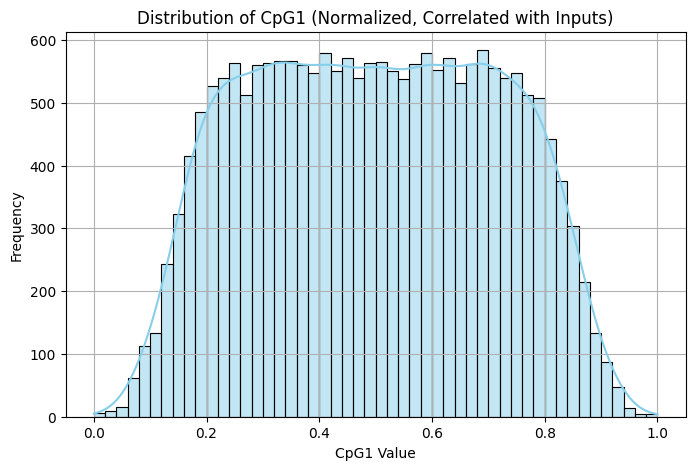

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# -----------------------------------------------------------------
num_samples = 20000
df_inputs = pd.DataFrame({
    'aqi': np.random.choice(['Low', 'Medium', 'High'], num_samples),
    'stress': np.random.choice(['Low', 'Medium', 'High'], num_samples),
    'physical_activity': np.random.choice(['Low', 'Medium', 'High'], num_samples),
    'asthma': np.random.choice(['Yes', 'No'], num_samples),
    'gender': np.random.choice(['Male', 'Female'], num_samples),
    'age': np.random.randint(18, 80, num_samples)
})
# -----------------------------------------------------------------

# Step 1: One-hot encode categorical inputs
categorical_cols = ['aqi', 'stress', 'physical_activity', 'asthma', 'gender']
df_encoded_inputs = pd.get_dummies(df_inputs, columns=categorical_cols, drop_first=True)

# Final input matrix
input_matrix = df_encoded_inputs.values

# Step 2: Generate CpG values with correlation + noise
num_cpg_sites = 353
cpg_data = {}

for i in range(num_cpg_sites):
    # Random weights and bias
    weights = np.random.normal(0, 0.05, input_matrix.shape[1])
    bias = np.random.normal(0.5, 0.1)

    # Linear combination + noise
    linear_output = np.dot(input_matrix, weights) + bias
    noise = np.random.normal(0, 0.05, size=linear_output.shape)
    cpg_values = linear_output + noise

    # Normalize to [0, 1] while preserving distribution shape
    min_val = cpg_values.min()
    max_val = cpg_values.max()
    cpg_values = (cpg_values - min_val) / (max_val - min_val)

    cpg_data[f'CpG{i+1}'] = cpg_values

# Step 3: Combine CpG values with inputs
df_cpg = pd.DataFrame(cpg_data)
df_full = pd.concat([df_inputs, df_cpg], axis=1)

# Step 4: Visualize distribution of one CpG site (e.g., CpG1)
plt.figure(figsize=(8, 5))
sns.histplot(df_full['CpG1'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of CpG1 (Normalized, Correlated with Inputs)")
plt.xlabel("CpG1 Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
# Save to CSV
df_full.to_csv("regenerated_epigenetic_dataset.csv", index=False)
print("✅ Dataset saved as 'regenerated_epigenetic_dataset.csv'")


✅ Dataset saved as 'regenerated_epigenetic_dataset.csv'


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("/content/regenerated_epigenetic_dataset.csv")

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values[missing_values > 0])


Missing values in each column:
 Series([], dtype: int64)


In [ ]:
# Drop rows with any missing values
df.dropna(inplace=True)

# Confirm removal
print("Remaining shape after dropping missing:", df.shape)


Remaining shape after dropping missing: (20000, 359)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Select categorical columns
categorical_cols = ['aqi', 'stress', 'physical_activity', 'asthma', 'gender']

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("Shape after encoding:", df_encoded.shape)


Shape after encoding: (20000, 362)


In [ ]:
# Features (inputs)
X = df_encoded.drop(columns=[f'CpG{i+1}' for i in range(353)])

# Targets (outputs)
Y = df_encoded[[f'CpG{i+1}' for i in range(353)]]

print("X shape:", X.shape)
print("Y shape:", Y.shape)


X shape: (20000, 9)
Y shape: (20000, 353)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Train set size:", X_train.shape, Y_train.shape)
print("Test set size:", X_test.shape, Y_test.shape)


Train set size: (16000, 9) (16000, 353)
Test set size: (4000, 9) (4000, 353)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# Break outputs into chunks
chunk_size = 50
for start in range(0, 353, chunk_size):
    end = min(start + chunk_size, 353)
    Y_chunk = Y_train[[f'CpG{i+1}' for i in range(start, end)]]
    model = MultiOutputRegressor(RandomForestRegressor(n_estimators=50, n_jobs=-1))
    model.fit(X_train, Y_chunk)
    print(f"✅ Trained CpG{start+1} to CpG{end}")


✅ Trained CpG1 to CpG50
✅ Trained CpG51 to CpG100
✅ Trained CpG101 to CpG150
✅ Trained CpG151 to CpG200
✅ Trained CpG201 to CpG250
✅ Trained CpG251 to CpG300
✅ Trained CpG301 to CpG350
✅ Trained CpG351 to CpG353


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Storage for evaluation
mse_scores = {}
r2_scores = {}


In [ ]:
# Evaluation loop — use same chunking logic
chunk_size = 50
for start in range(0, 353, chunk_size):
    end = min(start + chunk_size, 353)
    cpg_columns = [f'CpG{i+1}' for i in range(start, end)]

    # Get the test chunk
    Y_chunk_test = Y_test[cpg_columns]

    # Use previously trained model
    model = MultiOutputRegressor(RandomForestRegressor(n_estimators=50, n_jobs=-1))
    model.fit(X_train, Y_train[cpg_columns])
    Y_pred = model.predict(X_test)

    # Metrics
    mse = mean_squared_error(Y_chunk_test, Y_pred)
    r2 = r2_score(Y_chunk_test, Y_pred)

    # Store
    mse_scores[f'{start+1}-{end}'] = mse
    r2_scores[f'{start+1}-{end}'] = r2

    print(f"✅ CpG{start+1}–CpG{end} | MSE: {mse:.4f} | R²: {r2:.4f}")


✅ CpG1–CpG50 | MSE: 0.0014 | R²: 0.9534
✅ CpG51–CpG100 | MSE: 0.0013 | R²: 0.9475
✅ CpG101–CpG150 | MSE: 0.0011 | R²: 0.9632
✅ CpG151–CpG200 | MSE: 0.0012 | R²: 0.9553
✅ CpG201–CpG250 | MSE: 0.0011 | R²: 0.9711
✅ CpG251–CpG300 | MSE: 0.0011 | R²: 0.9643
✅ CpG301–CpG350 | MSE: 0.0017 | R²: 0.9385
✅ CpG351–CpG353 | MSE: 0.0049 | R²: 0.7292


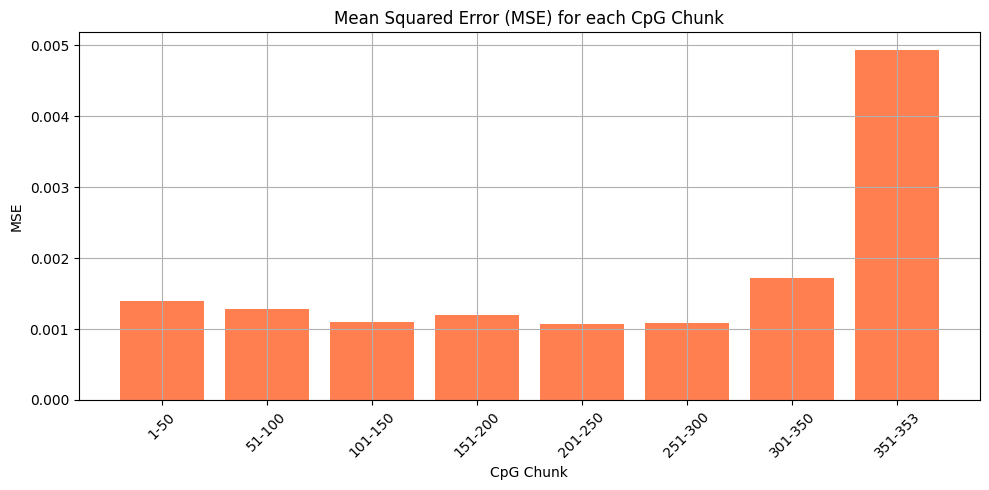

In [ ]:
# Plotting MSE
plt.figure(figsize=(10, 5))
plt.bar(mse_scores.keys(), mse_scores.values(), color='coral')
plt.xticks(rotation=45)
plt.title("Mean Squared Error (MSE) for each CpG Chunk")
plt.xlabel("CpG Chunk")
plt.ylabel("MSE")
plt.tight_layout()
plt.grid(True)
plt.show()


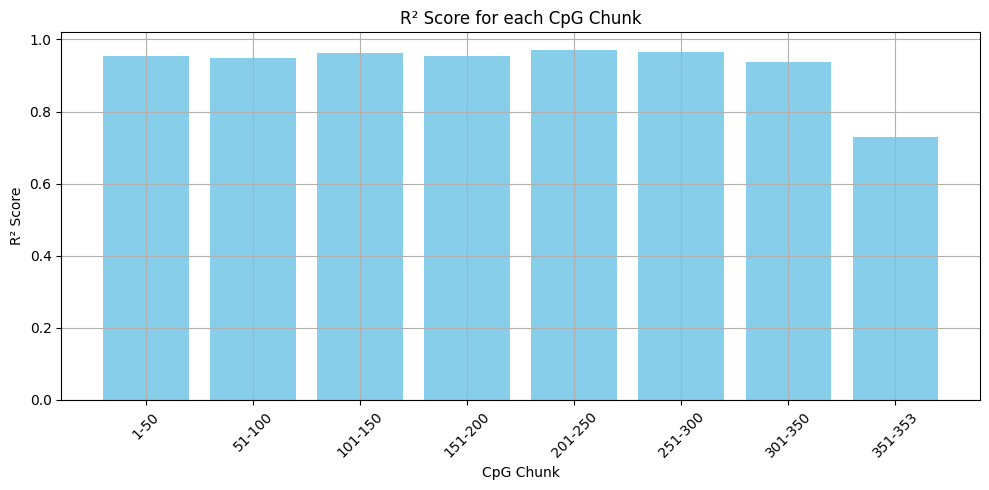

In [ ]:
# Plotting R²
plt.figure(figsize=(10, 5))
plt.bar(r2_scores.keys(), r2_scores.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title("R² Score for each CpG Chunk")
plt.xlabel("CpG Chunk")
plt.ylabel("R² Score")
plt.tight_layout()
plt.grid(True)
plt.show()


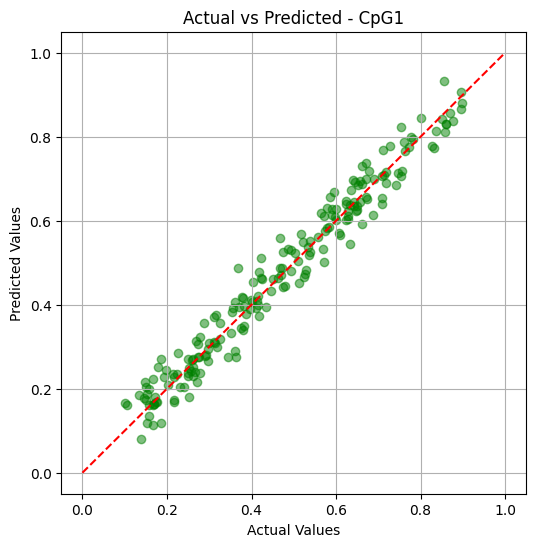

In [ ]:
# Example: Actual vs predicted for CpG1
import numpy as np

cpg = 'CpG1'
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=50, n_jobs=-1))
model.fit(X_train, Y_train[[cpg]])
Y_pred = model.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(Y_test[cpg].values[:200], Y_pred[:200], color='green', alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.title(f"Actual vs Predicted - {cpg}")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()


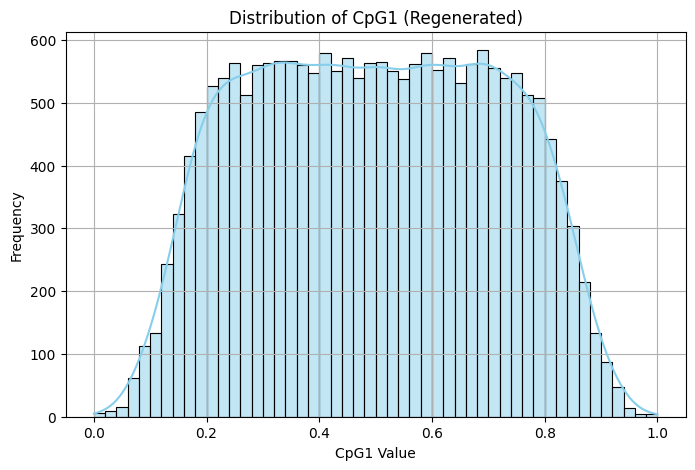

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df['CpG1'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of CpG1 (Regenerated)")
plt.xlabel("CpG1 Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
# Predict for CpG1 to CpG50
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# Load test chunk
Y_test_chunk = Y_test[[f'CpG{i+1}' for i in range(50)]]

# Reuse the same model structure
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=50, n_jobs=-1))
model.fit(X_train, Y_train[[f'CpG{i+1}' for i in range(50)]])
Y_pred_chunk = model.predict(X_test)

# Convert prediction to DataFrame for easier plotting
df_pred = pd.DataFrame(Y_pred_chunk, columns=[f'CpG{i+1}' for i in range(50)])


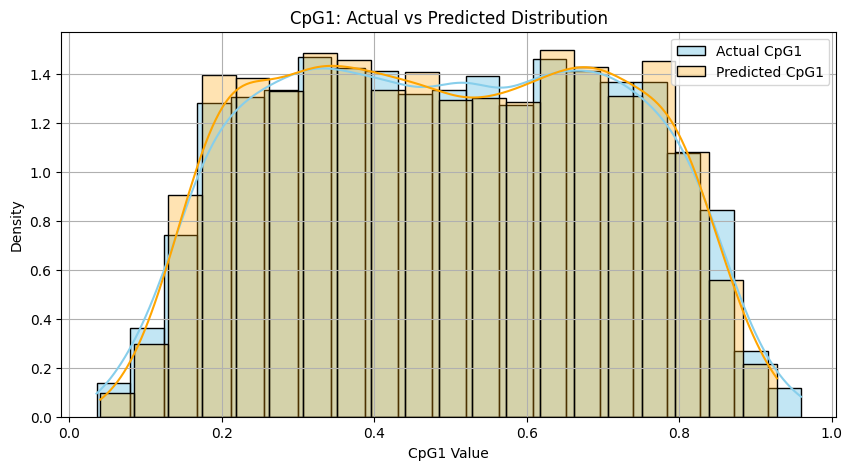

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# CpG1 actual and predicted
actual = Y_test_chunk['CpG1']
predicted = df_pred['CpG1']

# Plot
plt.figure(figsize=(10, 5))
sns.histplot(actual, color='skyblue', label='Actual CpG1', kde=True, stat="density")
sns.histplot(predicted, color='orange', label='Predicted CpG1', kde=True, stat="density", alpha=0.3)
plt.title("CpG1: Actual vs Predicted Distribution")
plt.xlabel("CpG1 Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

save_path = "/content/drive/MyDrive/epigenetic_models"
os.makedirs(save_path, exist_ok=True)


In [ ]:
import joblib
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

chunk_size = 50
chunk_map = []

for start in range(0, 353, chunk_size):
    end = min(start + chunk_size, 353)
    Y_chunk = Y_train[[f'CpG{i+1}' for i in range(start, end)]]

    model = MultiOutputRegressor(RandomForestRegressor(n_estimators=50, n_jobs=-1))
    model.fit(X_train, Y_chunk)

    filename = f"{save_path}/cpg_model_{start+1}_to_{end}.pkl"
    joblib.dump(model, filename)
    print(f"✅ Saved model: {filename}")

    chunk_map.append((start+1, end))


✅ Saved model: /content/drive/MyDrive/epigenetic_models/cpg_model_1_to_50.pkl
✅ Saved model: /content/drive/MyDrive/epigenetic_models/cpg_model_51_to_100.pkl
✅ Saved model: /content/drive/MyDrive/epigenetic_models/cpg_model_101_to_150.pkl
✅ Saved model: /content/drive/MyDrive/epigenetic_models/cpg_model_151_to_200.pkl
✅ Saved model: /content/drive/MyDrive/epigenetic_models/cpg_model_201_to_250.pkl
✅ Saved model: /content/drive/MyDrive/epigenetic_models/cpg_model_251_to_300.pkl
✅ Saved model: /content/drive/MyDrive/epigenetic_models/cpg_model_301_to_350.pkl
✅ Saved model: /content/drive/MyDrive/epigenetic_models/cpg_model_351_to_353.pkl


In [ ]:
# Save input feature column names
joblib.dump(list(X_train.columns), f"{save_path}/feature_columns.pkl")

# Save chunk metadata
joblib.dump(chunk_map, f"{save_path}/model_chunk_ranges.pkl")

print("✅ Saved feature columns and chunk map")


✅ Saved feature columns and chunk map


In [ ]:
import pandas as pd
import numpy as np
import joblib
import os
import gc

# 🔧 Set your model directory path
model_dir = "/content/drive/MyDrive/epigenetic_models"  # Adjust if different

# ✅ Efficient Predictor Function
def predict_all_cpg(input_df, model_dir=model_dir):
    # Load saved metadata
    chunk_map = joblib.load(os.path.join(model_dir, "model_chunk_ranges.pkl"))
    feature_columns = joblib.load(os.path.join(model_dir, "feature_columns.pkl"))

    # Preprocess input
    input_encoded = pd.get_dummies(input_df)
    for col in feature_columns:
        if col not in input_encoded:
            input_encoded[col] = 0
    input_encoded = input_encoded[feature_columns]

    all_preds = []

    # Load and predict each chunk one by one
    for (start, end) in chunk_map:
        filename = os.path.join(model_dir, f"cpg_model_{start}_to_{end}.pkl")
        model = joblib.load(filename)
        preds = model.predict(input_encoded)
        all_preds.append(preds)
        del model
        gc.collect()  # Force garbage collection to free RAM

    # Combine predictions
    full_pred = np.concatenate(all_preds, axis=1)
    columns = [f"CpG{i+1}" for i in range(full_pred.shape[1])]
    return pd.DataFrame(full_pred, columns=columns)

# 🧪 Sample user input (you can modify this)
sample_input = pd.DataFrame([{
    'aqi': 'high',
    'stress': 'low',
    'physical_activity': 'medium',
    'asthma': 'no',
    'gender': 'male',
    'chronological_age': 28
}])

# 🔮 Predict CpG1–CpG353
predicted_cpg_sites = predict_all_cpg(sample_input)
print(predicted_cpg_sites.head())


       CpG1      CpG2      CpG3      CpG4      CpG5      CpG6      CpG7  \
0  0.199695  0.919978  0.027843  0.928175  0.029886  0.847348  0.965771   

       CpG8      CpG9     CpG10  ...    CpG344    CpG345    CpG346    CpG347  \
0  0.066075  0.891916  0.081529  ...  0.908482  0.031596  0.245753  0.031607   

     CpG348    CpG349    CpG350    CpG351    CpG352    CpG353  
0  0.164652  0.880631  0.128253  0.356516  0.020807  0.657828  

[1 rows x 353 columns]


In [ ]:
print(f"\n✅ Total CpG sites predicted: {predicted_cpg_sites.shape[1]}")
print(f"CpG column names (first 10): {predicted_cpg_sites.columns[:].tolist()}")


✅ Total CpG sites predicted: 353
CpG column names (first 10): ['CpG1', 'CpG2', 'CpG3', 'CpG4', 'CpG5', 'CpG6', 'CpG7', 'CpG8', 'CpG9', 'CpG10', 'CpG11', 'CpG12', 'CpG13', 'CpG14', 'CpG15', 'CpG16', 'CpG17', 'CpG18', 'CpG19', 'CpG20', 'CpG21', 'CpG22', 'CpG23', 'CpG24', 'CpG25', 'CpG26', 'CpG27', 'CpG28', 'CpG29', 'CpG30', 'CpG31', 'CpG32', 'CpG33', 'CpG34', 'CpG35', 'CpG36', 'CpG37', 'CpG38', 'CpG39', 'CpG40', 'CpG41', 'CpG42', 'CpG43', 'CpG44', 'CpG45', 'CpG46', 'CpG47', 'CpG48', 'CpG49', 'CpG50', 'CpG51', 'CpG52', 'CpG53', 'CpG54', 'CpG55', 'CpG56', 'CpG57', 'CpG58', 'CpG59', 'CpG60', 'CpG61', 'CpG62', 'CpG63', 'CpG64', 'CpG65', 'CpG66', 'CpG67', 'CpG68', 'CpG69', 'CpG70', 'CpG71', 'CpG72', 'CpG73', 'CpG74', 'CpG75', 'CpG76', 'CpG77', 'CpG78', 'CpG79', 'CpG80', 'CpG81', 'CpG82', 'CpG83', 'CpG84', 'CpG85', 'CpG86', 'CpG87', 'CpG88', 'CpG89', 'CpG90', 'CpG91', 'CpG92', 'CpG93', 'CpG94', 'CpG95', 'CpG96', 'CpG97', 'CpG98', 'CpG99', 'CpG100', 'CpG101', 'CpG102', 'CpG103', 'CpG104', 'CpG

In [16]:
!pip install -q huggingface_hub


In [17]:
from huggingface_hub import notebook_login
notebook_login()


In [18]:
from huggingface_hub import HfApi, HfFolder, upload_file
import os

repo_id = "Ankush6866c/AgingIQ"  # Replace with your actual repo
folder_path = "/content/drive/MyDrive/epigenetic_models"

for filename in os.listdir(folder_path):
    if filename.endswith(".pkl"):
        file_path = os.path.join(folder_path, filename)
        print(f"Uploading {filename}...")
        upload_file(
            path_or_fileobj=file_path,
            path_in_repo=filename,
            repo_id=repo_id,
            repo_type="model"
        )


Uploading cpg_model_1_to_50.pkl...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


cpg_model_1_to_50.pkl:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Uploading cpg_model_51_to_100.pkl...


cpg_model_51_to_100.pkl:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Uploading cpg_model_101_to_150.pkl...


cpg_model_101_to_150.pkl:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Uploading cpg_model_151_to_200.pkl...


cpg_model_151_to_200.pkl:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Uploading cpg_model_201_to_250.pkl...


cpg_model_201_to_250.pkl:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Uploading cpg_model_251_to_300.pkl...


cpg_model_251_to_300.pkl:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Uploading cpg_model_301_to_350.pkl...


cpg_model_301_to_350.pkl:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Uploading cpg_model_351_to_353.pkl...


cpg_model_351_to_353.pkl:   0%|          | 0.00/113M [00:00<?, ?B/s]

Uploading feature_columns.pkl...


feature_columns.pkl:   0%|          | 0.00/152 [00:00<?, ?B/s]

Uploading model_chunk_ranges.pkl...


model_chunk_ranges.pkl:   0%|          | 0.00/69.0 [00:00<?, ?B/s]